# Car Acquisition Classifier


The given dataset contains a dataset of cars purchased at an auction. This is an EDA to python classifier notebook that aims to classify whether a given car is a good/bad buy. The dataset contains 32 Independent variables (C3-C34) and 1 predictor variable (C2)

## Part1: Exploratory Data Analysis(EDA)

In [0]:
!pip install numpy pandas matplotlib seaborn

In [0]:
#import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

#set plot properties
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set(context = 'notebook', style = 'darkgrid', palette = 'deep', font = 'Helvetica')

warnings.filterwarnings('ignore')

In [0]:
#mount google drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

#enter relative path to train/test data
train_data_path = '/content/drive/My Drive/Colab Notebooks/car classifier/bad_buy_prediction_data/training.csv'
test_data_path = '/content/drive/My Drive/Colab Notebooks/car classifier/bad_buy_prediction_data/test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

train_data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,Transmission,WheelTypeID,WheelType,VehOdo,Nationality,Size,TopThreeAmericanName,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,AUTO,1.0,Alloy,89046,OTHER ASIAN,MEDIUM,OTHER,8155.0,9829.0,11636.0,13600.0,7451.0,8552.0,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,AUTO,1.0,Alloy,93593,AMERICAN,LARGE TRUCK,CHRYSLER,6854.0,8383.0,10897.0,12572.0,7456.0,9222.0,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,AUTO,2.0,Covers,73807,AMERICAN,MEDIUM,CHRYSLER,3202.0,4760.0,6943.0,8457.0,4035.0,5557.0,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,AUTO,1.0,Alloy,65617,AMERICAN,COMPACT,CHRYSLER,1893.0,2675.0,4658.0,5690.0,1844.0,2646.0,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,MANUAL,2.0,Covers,69367,AMERICAN,COMPACT,FORD,3913.0,5054.0,7723.0,8707.0,3247.0,4384.0,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [0]:
#checking for total null values
print('Checking total null values in the dataset...', train_data.isnull().sum(), sep='\n')

Checking total null values in the dataset...
RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurren

It can be seen that majority of the features don't have PRIMEUNIT/AUCGUART feature specified, and so they can be ignored instead of filling 96% of the dataset with placeholder values.

Check the class distribution within the training set to see if any undersampling/oversampling has to be done eventually

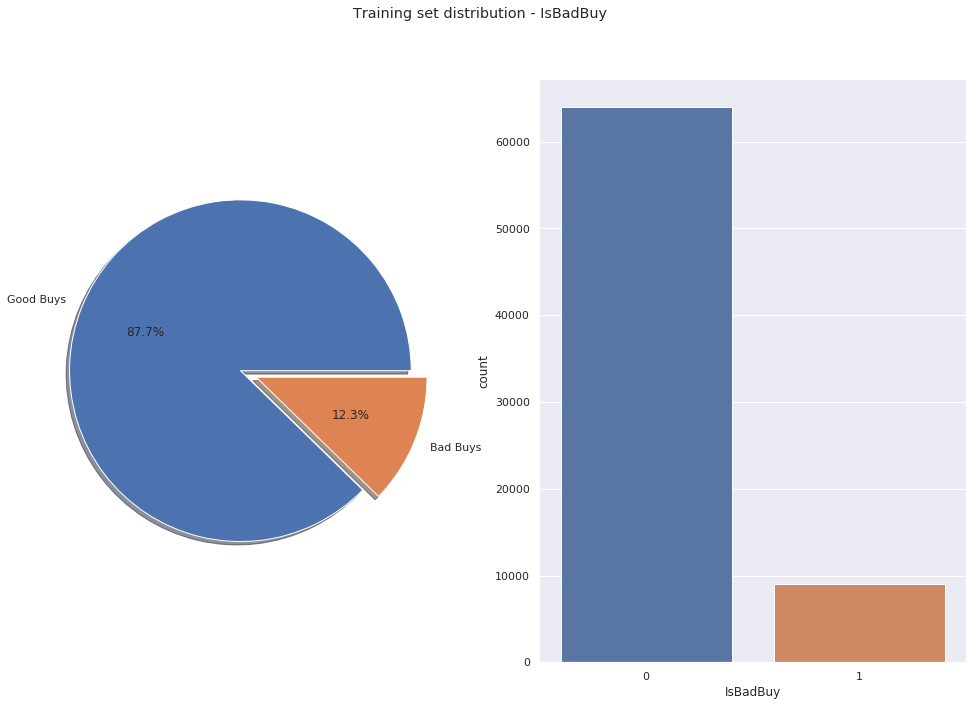

In [0]:
f,ax=plt.subplots(1,2,figsize=(15,10))
f.suptitle('Training set distribution - IsBadBuy')
train_data['IsBadBuy'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True, labels = ('Good Buys','Bad Buys'))
ax[0].set_ylabel('')

#visualize as count plot
sns.countplot('IsBadBuy',data=train_data,ax=ax[1])
plt.show()

From the chart, about 87.7% of the dataset (or 64,007 samples) are good buys, while the remaining 12.3% (8976 samples) are BadBuys. Exploring through the features will give a more clearer insight for predicting the IsBadBuy class

#### Analyzing the dataset features

All the features in the dataset is run through here and their insignificance/redundancy/influence on final prediction is investigated

#### VehicleAge Vs VehicleYear

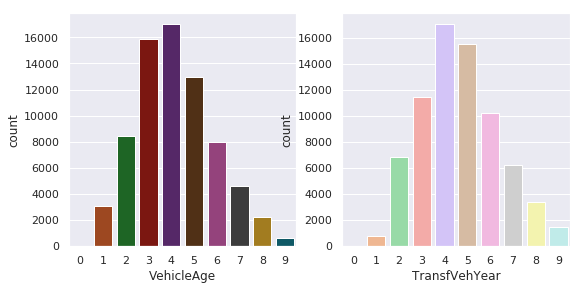

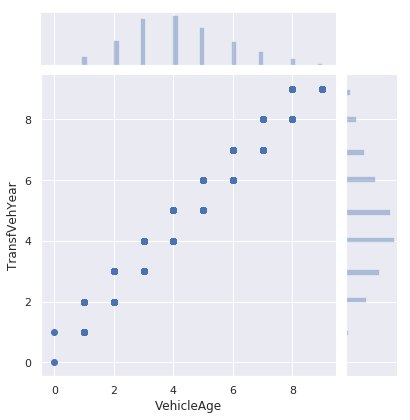

In [0]:
#duplicate dataset before EDA
data=train_data.copy()

#Create a linearly tranformed vehicle year col->'TransfVehYear'
data['TransfVehYear'] = 2010 - data['VehYear']
f,ax = plt.subplots(1,2,figsize=(8,4))
ax[0] = sns.countplot(x="VehicleAge", data=data, palette='dark', ax=ax[0])
ax[1] = sns.countplot(x="TransfVehYear", data=data, palette='pastel', ax=ax[1])
sns.jointplot(x='VehicleAge',y='TransfVehYear',data=data)
plt.show()

From the above plots, it can be inferred that the Vehicle Age (The Years elapsed since the manufacturer's year) and Vehicle Year (The manufacturer's year of the vehicle) are highly correlated, if not the same. The Vehicle Year can then be removed from our analysis.

Also note from the gaussian distribution of the jointplot that, the vehicles with an age of 3-5 years form the majority (62.85%) of our training set.



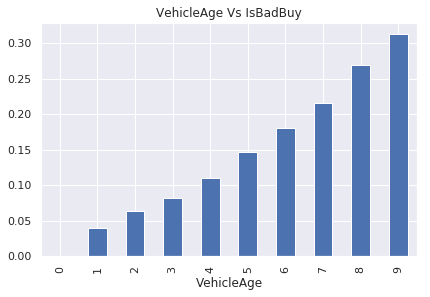

In [0]:
data.groupby("VehicleAge").mean()["IsBadBuy"].plot.bar(title = "VehicleAge Vs IsBadBuy")
plt.show()

The probability of the a car being a BadBuy is also proven to increase with the age of the vehicle. This direct correlation makes sense as the time frame of the vehicles considered (<10 years) are short enough to not involve the antique/vintage car classes

#### PurchDate, Make & Color

In [0]:
#Get the year of purchase from the purchase date
data['PurchYear'] = data.PurchDate.apply(lambda x : x[-4:])

veh_min=int(data['VehYear'].min())
veh_max=int(data['VehYear'].max())
Purch_min=int(data['PurchYear'].min())
Purch_max=int(data['PurchYear'].max())


print('The manufacturing dates of vehicles ranged from {0} to {1}'.format(veh_min,veh_max))
print('The date of purchase of these vehicles ranged from {0} to {1}'.format(Purch_min,Purch_max))

The manufacturing dates of vehicles ranged from 2001 to 2010
The date of purchase of these vehicles ranged from 2009 to 2010


While the vehicles in the datset were manufactured in the last decade (10 years), these vehicles were purchased between a time interval of only 1 year (about 10% of manufactured timeline). 

Since the PurchDate variation is too insignificant, relative to purchased date, it can be ignored for the current datset.

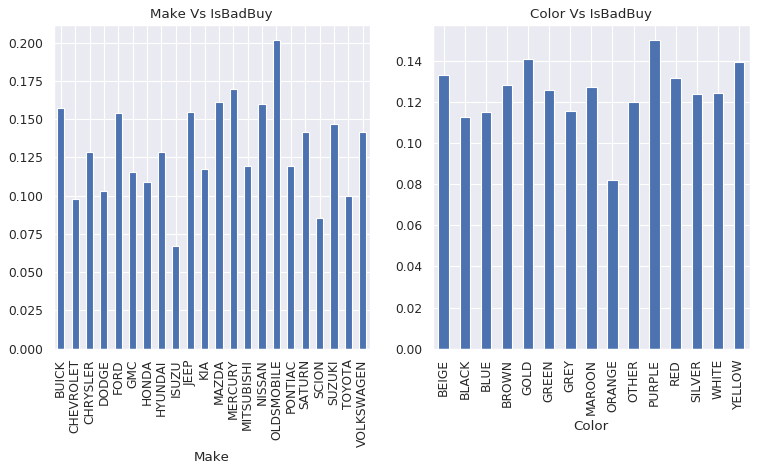

In [0]:
f,ax = plt.subplots(1,2,figsize=(10,5), dpi = 80, facecolor='w', edgecolor='k')
ax[0] = data.groupby('Make').agg([np.mean,np.size])['IsBadBuy'].query('size > 100')['mean'].plot.bar(figsize=(10,5), title = "Make Vs IsBadBuy", ax=ax[0])
ax[1] = data.groupby('Color').agg([np.mean,np.size])['IsBadBuy'].query('size > 100')['mean'].plot.bar(figsize=(10,5), title = "Color Vs IsBadBuy", ax=ax[1])
plt.show()

From the above plots, it is visible that while neither the Car make nor the car color are definitive indicators of whether a given car is a bad buy or not, they do exert some influence over the end result. To avoid less available training data of specific makes/color (Hummer, Plymouth, Scion all of which have 1/2 samples in the whole datset) from distorting the graph, only the samples with more than 100 occurences are plotted here

Also about **863 different SubModels** have been used to collect the dataset which suggests less sample size for each SubModel (and even lesser for defective BadBuys) owing to the increase in SubModelcategory

#### Transmission & WheelType

In [0]:
#Transmission df has both MANUAL & Manual labels. Normalize them.
data['lower_trans'] = data['Transmission'].str.lower()
pd.crosstab(data.lower_trans,data.IsBadBuy, margins=True).style.background_gradient(cmap='summer_r') #cmap=viridis, cmap=cm


IsBadBuy,0,1,All
lower_trans,,,
auto,61722,8676,70398
manual,2277,299,2576
All,63999,8975,72974


It can be inferred from the above cross tab that the majority(96.4%) of the dataset contained Automatic Transmission samples. Out of the total sample space, 
*   12.32% of the auto transmission cars are Bad Buys
*   11.60% of the auto transmission cars are Bad Buys

Thus, even though the dataset is heavily balanced towards the Dataset with Auto-transmission, its value doesn't seem to influence whether the car is a bad buy or not and can be ignored



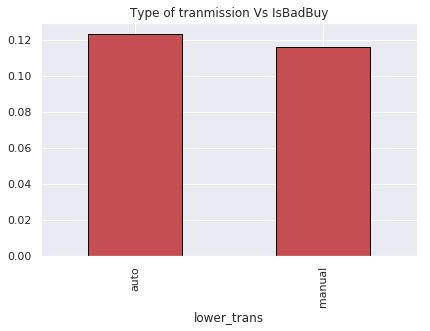

In [0]:
data.groupby("lower_trans").mean()["IsBadBuy"].plot.bar(title = "Type of tranmission Vs IsBadBuy", color = 'C3', edgecolor='black')
plt.show()

Also, the WheelTypeID is just the one-to-one mapped values of WheelType featureset and so WheelType can be ignored

#### Brand Value ROI, Nationality & Size

The mean acquisition cost for Chrysler is  6903.403496730629
The mean acquisition cost for Ford is  6400.546041412911
The mean acquisition cost for GM is  6692.150219246266


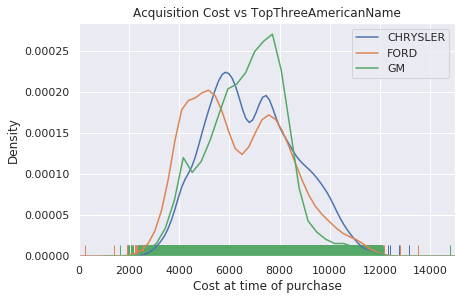

In [0]:
target_0 = data[data.TopThreeAmericanName == 'CHRYSLER']
target_1 = data[data.TopThreeAmericanName == 'FORD']
target_2 = data[data.TopThreeAmericanName == 'GM']

sns.distplot(target_0[['VehBCost']], hist=False, rug=True, kde = True, label='CHRYSLER')
sns.distplot(target_1[['VehBCost']], hist=False, rug=True, kde = True, label='FORD')
sns.distplot(target_2[['VehBCost']], hist=False, rug=True, kde = True, label='GM')
plt.xlim(0, 15000)
plt.title('Acquisition Cost vs TopThreeAmericanName')
plt.xlabel('Cost at time of purchase')
plt.ylabel('Density')

print('The mean acquisition cost for Chrysler is ', target_0.VehBCost.mean())
print('The mean acquisition cost for Ford is ', target_1.VehBCost.mean())
print('The mean acquisition cost for GM is ', target_2.VehBCost.mean())

It can be inferred from the above distplot that while the acquisition cost is ditributed evenly around the mean for Ford & Chrysler vehicles, the acquisition cost for GM vehicles are more on the higher end than the other two.

This finding gives a key insight when juxtaposed with the below plot,

Text(0, 0.5, 'Density')

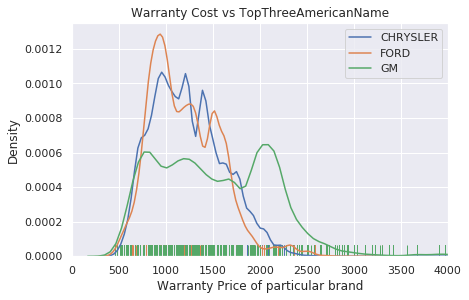

In [0]:
target_0 = data[data.TopThreeAmericanName == 'CHRYSLER']
target_1 = data[data.TopThreeAmericanName == 'FORD']
target_2 = data[data.TopThreeAmericanName == 'GM']

sns.distplot(target_0[['WarrantyCost']], hist=False, rug=True, kde = True, label='CHRYSLER')
sns.distplot(target_1[['WarrantyCost']], hist=False, rug=True, kde = True, label='FORD')
sns.distplot(target_2[['WarrantyCost']], hist=False, rug=True, kde = True, label='GM')
plt.xlim(0, 4000)
plt.title('Warranty Cost vs TopThreeAmericanName')
plt.xlabel('Warranty Price of particular brand')
plt.ylabel('Density')

From the above two plots it can be inferred that while GM vehicles tend to cost more, their warranty prices are evenly distributed (not reflecting thier acquisition cost). While Ford offers less warranty prices then Chrysler for about the same range of acquisition costs. This stat is observed across 83.6% of the dataset with top three american brands.

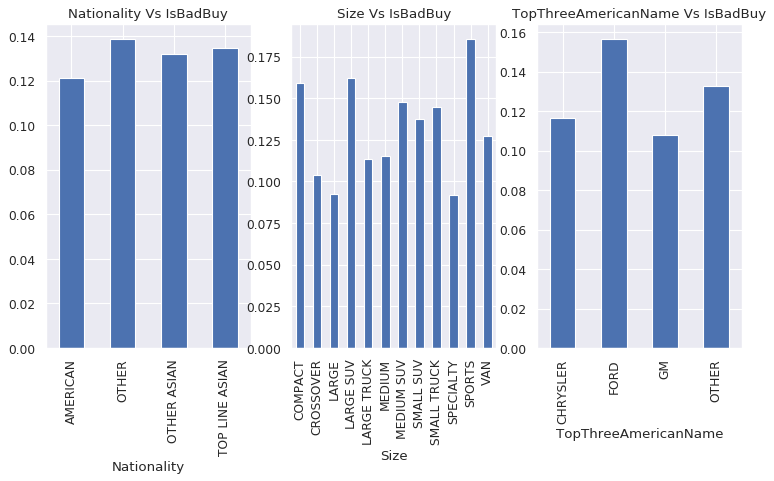

In [0]:
f,ax = plt.subplots(1,3,figsize=(10,5), dpi = 80, facecolor='w', edgecolor='k')
ax[0] = data.groupby('Nationality').agg([np.mean,np.size])['IsBadBuy'].query('size > 100')['mean'].plot.bar(figsize=(10,5), title = "Nationality Vs IsBadBuy", ax=ax[0])
ax[1] = data.groupby('Size').agg([np.mean,np.size])['IsBadBuy'].query('size > 100')['mean'].plot.bar(figsize=(10,5), title = "Size Vs IsBadBuy", ax=ax[1])
ax[2] = data.groupby('TopThreeAmericanName').agg([np.mean,np.size])['IsBadBuy'].query('size > 100')['mean'].plot.bar(figsize=(10,5), title = "TopThreeAmericanName Vs IsBadBuy", ax=ax[2])
plt.show()

From the above charts & below cross tables, it can be inferred that while Nationality doesn't affect whether a car is Bad, size & TopThreeAmericanName (as established before in the previous dist_plots) do exert some infuence over the final result.

In [0]:
pd.crosstab(data.TopThreeAmericanName,data.IsBadBuy, margins=False).style.background_gradient(cmap='viridis')


IsBadBuy,0,1
TopThreeAmericanName,,
CHRYSLER,20674,2725
FORD,10389,1926
GM,22578,2736
OTHER,10361,1589


In [0]:
pd.crosstab(data.Size,data.IsBadBuy, margins=False).style.background_gradient(cmap='summer_r')


IsBadBuy,0,1
Size,,
COMPACT,6060,1145
CROSSOVER,1576,183
LARGE,8032,818
LARGE SUV,1201,232
LARGE TRUCK,2810,360
MEDIUM,27244,3541
MEDIUM SUV,6897,1193
SMALL SUV,1963,313
SMALL TRUCK,739,125


#### VehBCost, WarrantyCost & IsOnlineSale

Vehicle Acquisition costs for good and bad buys in the dataset:


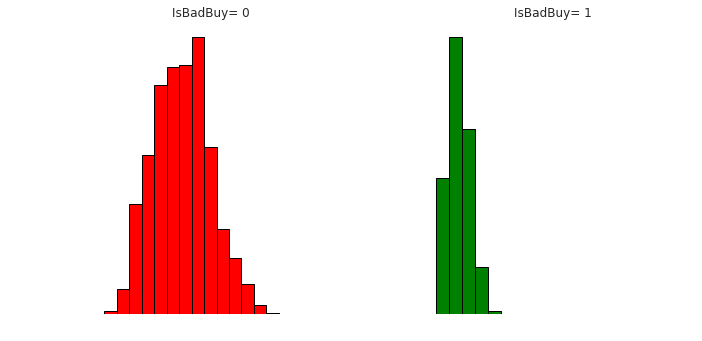

In [0]:
f,ax=plt.subplots(1,2,figsize=(10,5))
data[data['IsBadBuy']==0].VehBCost.plot.hist(ax=ax[0],bins=20,edgecolor='black',color='red')
ax[0].set_title('IsBadBuy= 0')
x1=list(range(0,15000,500))
ax[0].set_xticks(x1)
ax[0].axis('off')

data[data['IsBadBuy']==1].VehBCost.plot.hist(ax=ax[1],bins=20,edgecolor='black',color='green')
ax[1].set_title('IsBadBuy= 1')
x2=list(range(0,15000,500))
ax[1].set_xticks(x2)
ax[1].axis('off')

print('Vehicle Acquisition costs for good and bad buys in the dataset:')
plt.show()

The above plot comparison gives an insight that while good buys are evenly distributed with their price range, bad buys usually tends to be cheaply priced (low-end range)

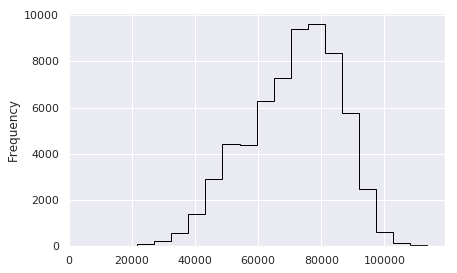

In [0]:
data[data['IsBadBuy']==0].VehOdo.plot.hist(bins=20,edgecolor='black',color='red', histtype='step')
x1=list(range(0,15000,500))
# plt.set_xticks(x1)

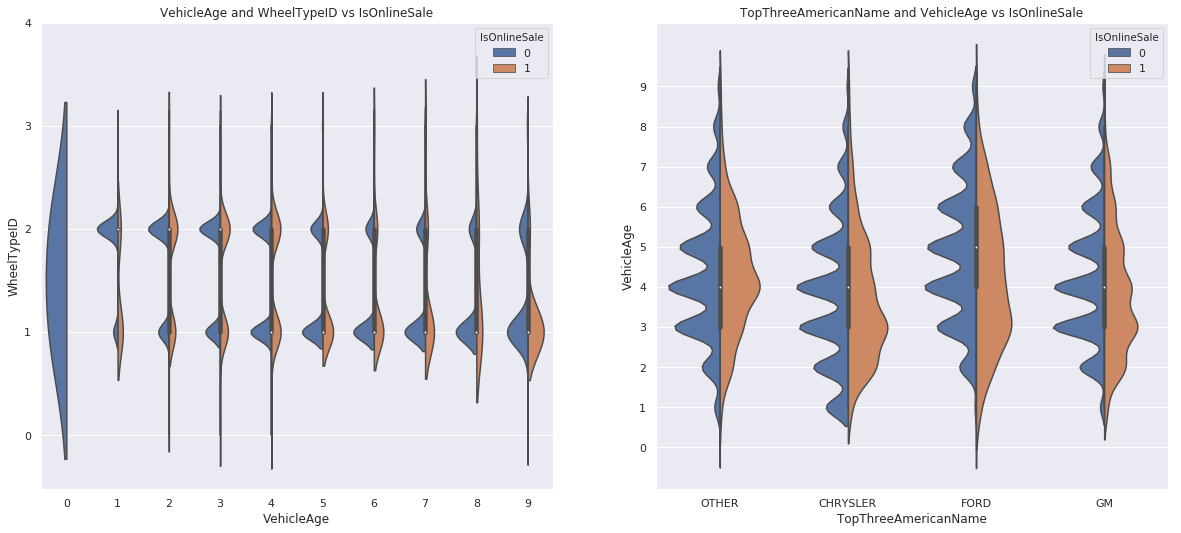

In [0]:
f,ax=plt.subplots(1,2,figsize=(18,8))
sns.violinplot("VehicleAge","WheelTypeID", hue="IsOnlineSale", data=data,split=True,ax=ax[0])
ax[0].set_title('VehicleAge and WheelTypeID vs IsOnlineSale')
ax[0].set_yticks(range(0,5,1))
sns.violinplot("TopThreeAmericanName","VehicleAge", hue="IsOnlineSale", data=data,split=True,ax=ax[1])
ax[1].set_title('TopThreeAmericanName and VehicleAge vs IsOnlineSale')
ax[1].set_yticks(range(0,10,1))
plt.show()

It can be inferred from the above violin-plots that more recent vehicles (Vehciles with age < 3) are increasingly being sold online. The distribution of vehicles from the top 3 brands sold online across different age buckets are similar too. While these results are inconclulsive, any insight must be taken with a pinch of salt as well as only about (<3%) of the dataset includes sample that were sold online

#### MMR price comparisons

(0, 15000)

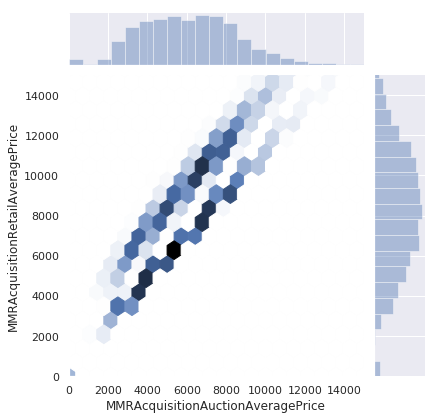

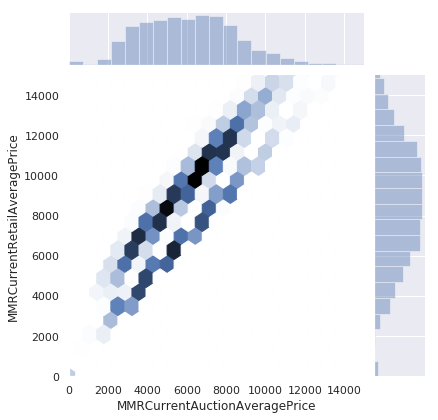

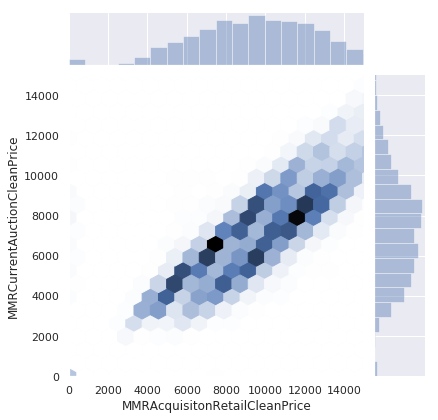

In [0]:
plot =  sns.jointplot(x='MMRAcquisitionAuctionAveragePrice',y='MMRAcquisitionRetailAveragePrice',data=data, kind ='hex')
plot.ax_marg_x.set_xlim(0, 15000)
plot.ax_marg_y.set_ylim(0, 15000)
plot =  sns.jointplot(x='MMRCurrentAuctionAveragePrice',y='MMRCurrentRetailAveragePrice',data=data, kind ='hex')
plot.ax_marg_x.set_xlim(0, 15000)
plot.ax_marg_y.set_ylim(0, 15000)
plot =  sns.jointplot(x='MMRAcquisitonRetailCleanPrice',y='MMRCurrentAuctionCleanPrice',data=data, kind ='hex')
plot.ax_marg_x.set_xlim(0, 15000)
plot.ax_marg_y.set_ylim(0, 15000)

The above joint plots all seem to imply that the MMR price values (varied across Acquisition/Current, Auction/Retails, or Average/Clean) all seem to be highly correlated. This can be conclusively verified (along with out other findings) in the below heatmap,

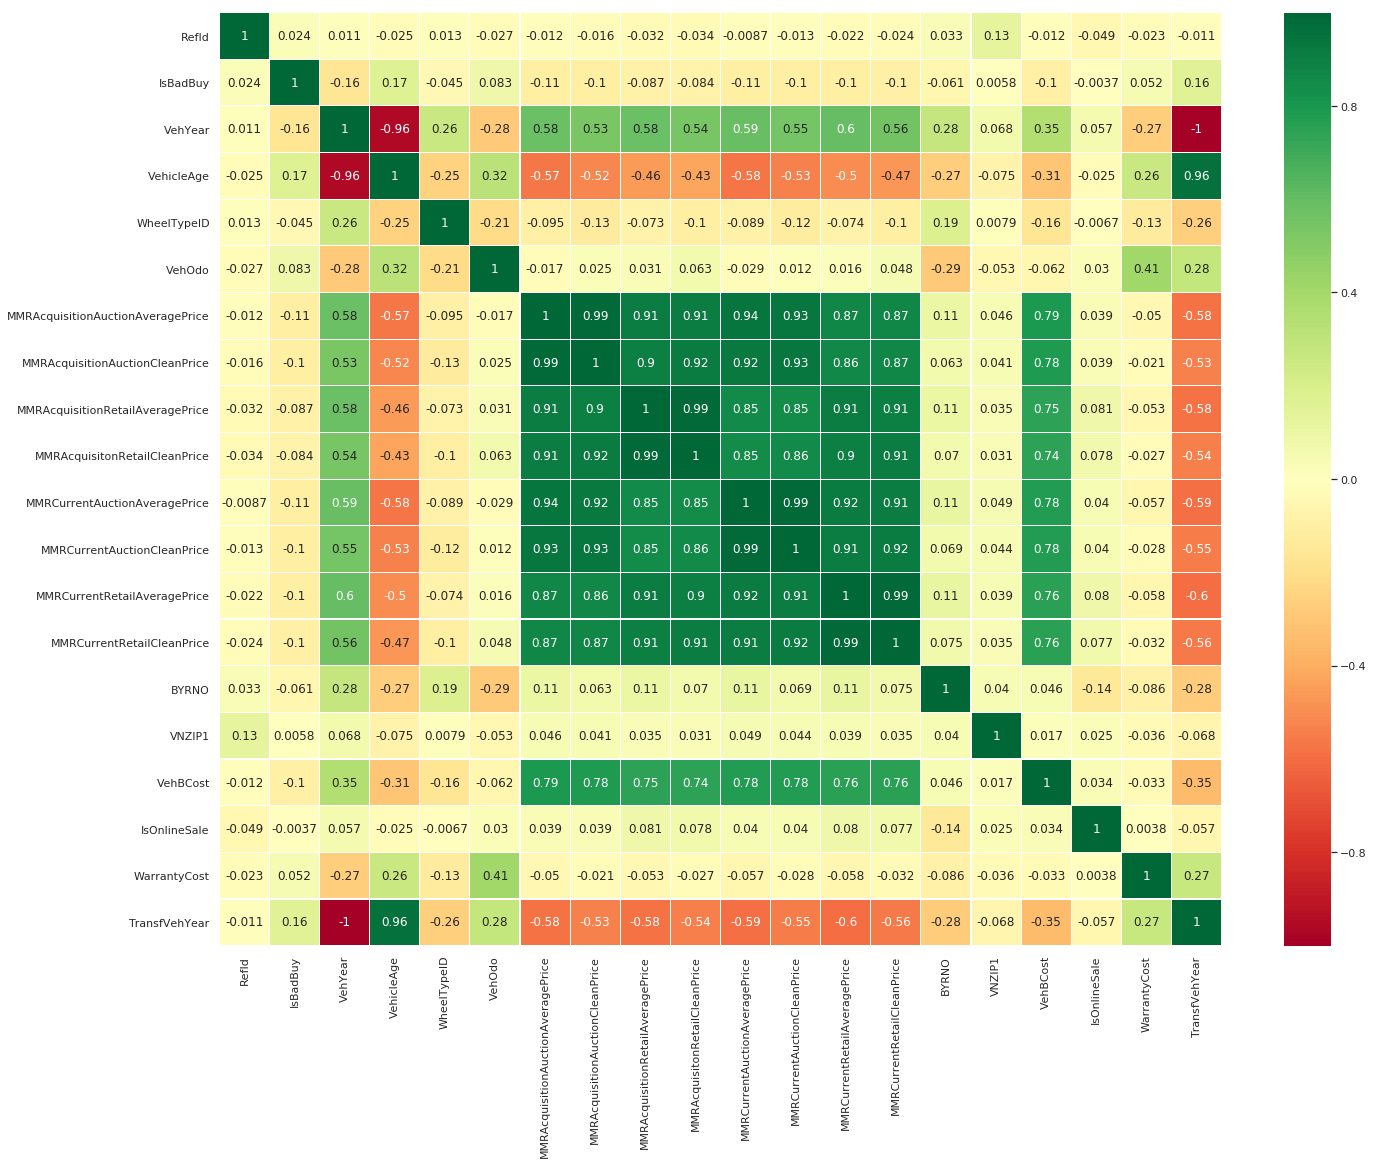

In [0]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,16)
plt.show()

Observing only the numeric features gives the following insights:

*    All eight MMR prices are indeed closely correlated (change in one leads to change in another with little to no variance). 
*    This **MultiColinearity** across the 8 dimensions can/must be reduced to 1 new ensemble feature (as the 8 features do not give any new information separately, reducing them to 1 compund feature helps increase the training time while also retaining the information provided)
*    The heatmap results also corroborate with our earlier conclusions of direct correlation between VehYear/VehAge/PurchDate and will show the non-correlation between Nationality and Transmission type with IsBadBuy when after encoding the string embeddings

#### Location of purchase & Buyer experience

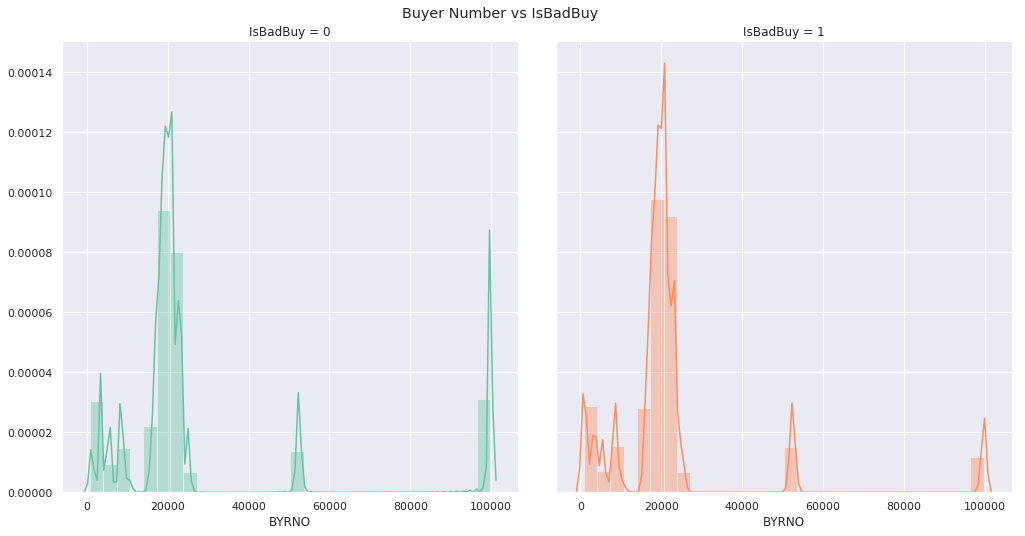

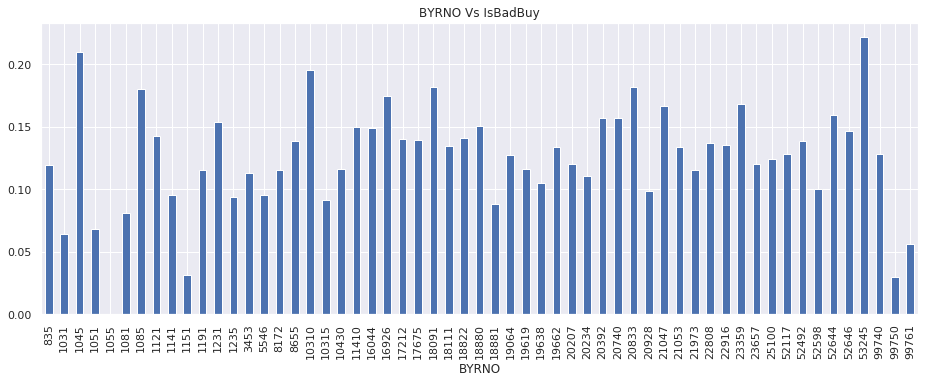

In [0]:
grid = sns.FacetGrid(data, col="IsBadBuy",hue = 'IsBadBuy' ,height=5, palette='Set2')
grid.map(sns.distplot,'BYRNO',bins = 30);
grid.fig.suptitle('Buyer Number vs IsBadBuy')
grid.fig.set_size_inches(15,8)
plt.show()

data.groupby('BYRNO').agg([np.mean,np.size])['IsBadBuy'].query('size > 10')['mean'].plot.bar(figsize=(14,5), title = "BYRNO Vs IsBadBuy")
plt.show()

As both the facet plots are distributed similarly, it can be inferred that the Buyer no doesn't seem to affect the outcome of the results (Good/Bad buy) as experiences buyers was initially expected to make better judgements along the way as the sample size increases.

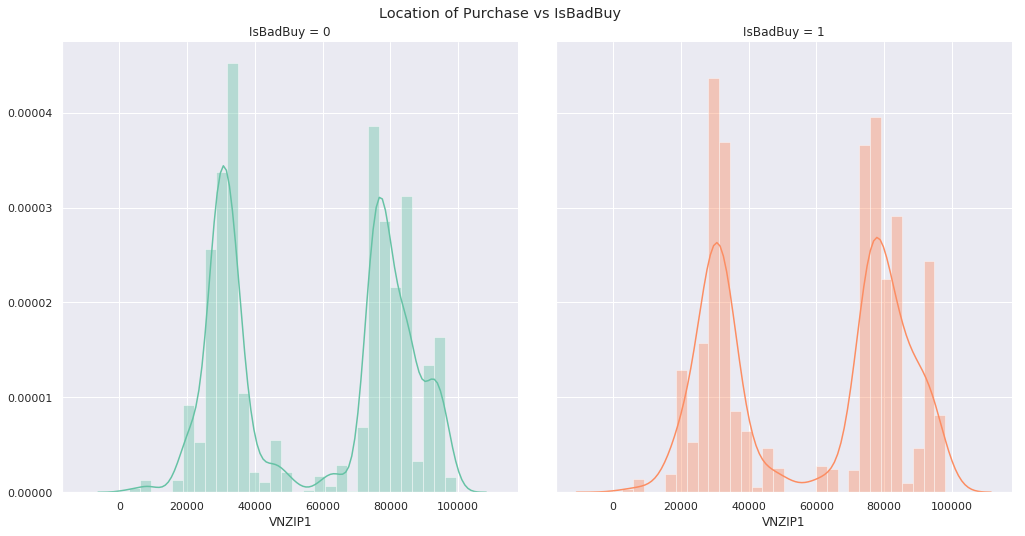

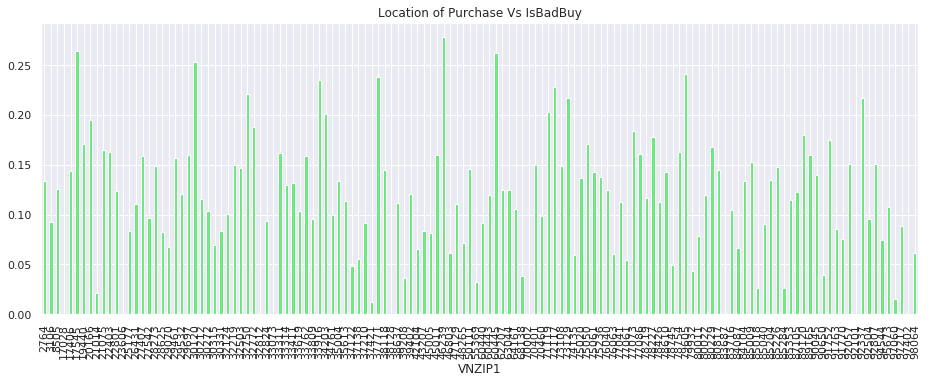

In [0]:
grid = sns.FacetGrid(data, col="IsBadBuy",hue = 'IsBadBuy' ,height=5, palette='Set2')
grid.map(sns.distplot,'VNZIP1',bins = 30);
grid.fig.suptitle('Location of Purchase vs IsBadBuy')
grid.fig.set_size_inches(15,8)
plt.show()

data.groupby('VNZIP1').agg([np.mean,np.size])['IsBadBuy'].query('size > 10')['mean'].plot.bar(
figsize=(14,5), color=(0.2, 0.9, 0.3, 0.7), title = "Location of Purchase Vs IsBadBuy")
plt.show()

Like Buyer No, the same can be said of the ZipCode & States as well from the above visualizations. More successfull buys are not likely to be made in transactions in/correlated with specific states/places.

# Part 2: Feature engineering & Modelling

The following features are removed from our training dataset,


*    PurchDate
*    VehYear
*    WheelType
*    Transmission
*    Nationality
*    PrimeUnit
*    AucGuart
*    BYRNO
*    VNZIP
*    IsOnlineSale

The following features are consolidated,


*    MMRAcquisitionAuctionAveragePrice
*    MMRAcquisitionAuctionCleanPrice
*    MMRAcquisitionRetailAveragePrice
*    MMRAcquisitonRetailCleanPrice
*    MMRCurrentAuctionAveragePrice
*    MMRCurrentAuctionCleanPrice
*    MMRCurrentRetailAveragePrice
*    MMRCurrentRetailCleanPrice


to form one new ensemble feature,

**MMRPriceDrop** = MMRAcquisitionRetailAveragePrice - MMRCurrentAuctionAveragePrice


by assuming the MMRAcquisitionRetailAveragePrice to denote the average retail price of the vehicle at the time of its release and MMRCurrentAuctionAveragePrice to denote the current average price of the said vehicle in auctions.

In [0]:
#add new compund feature to dataset
train_data['MMRPriceDrop'] = train_data.apply(lambda row: float(row.MMRAcquisitionRetailAveragePrice) - 
                                                          float(row.MMRCurrentAuctionAveragePrice), axis = 1) 

#form list of items to drop from the dataframe
drop_list = ['RefId','PurchDate','VehYear', 'WheelType', 'Transmission', 
             'Nationality', 'PRIMEUNIT', 'AUCGUART', 'BYRNO', 'VNZIP1',
             'IsOnlineSale','MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
             'MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice',
             'MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice',
             'MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice'] 

for itr in drop_list:
  if itr in train_data.columns:
    train_data = train_data.drop(columns=itr)

#preview dataset to verify changes with final 15 features
train_data.tail(n=2)

,IsBadBuy,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,WheelTypeID,VehOdo,Size,TopThreeAmericanName,VNST,VehBCost,WarrantyCost,MMRPriceDrop
72981,0,ADESA,3,CHEVROLET,IMPALA,LS,4D SEDAN LS,WHITE,1.0,79554,LARGE,GM,GA,7000.0,1974,844.0
72982,0,ADESA,3,MAZDA,MAZDA6,s,4D SEDAN S,SILVER,1.0,66855,MEDIUM,OTHER,GA,8000.0,1313,908.0


In [0]:
# factorize dataset columns before modelling
fact_cols = ['Auction','Make','Model','Trim','SubModel','Color', 'WheelTypeID',
            'Size','TopThreeAmericanName','VNST']
for itr in fact_cols:
  train_data[[itr]] = train_data[[itr]].stack().rank(method='dense').unstack()

#convert dataset columns to numeric type
num_cols = ['VehOdo','VehBCost','WarrantyCost','MMRPriceDrop']
for itr in list(train_data):
  train_data[itr] = train_data[itr].astype(float)

#scale the dataset to avoid biasing of features with large values  
train_data[list(train_data)] = scaler.fit_transform(train_data[list(train_data)])
  
#preview dataset    
train_data.tail(n=2)

,IsBadBuy,Auction,VehicleAge,Make,Model,Trim,SubModel,Color,WheelTypeID,VehOdo,Size,TopThreeAmericanName,VNST,VehBCost,WarrantyCost,MMRPriceDrop
72981,0.0,0.0,0.333333,0.09375,0.449153,0.413534,0.269142,0.933333,0.333333,0.673890,0.181818,0.666667,0.166667,0.153932,0.214895,0.422364
72982,0.0,0.0,0.333333,0.53125,0.560264,1.000000,0.305104,0.866667,0.333333,0.559373,0.454545,1.000000,0.166667,0.175926,0.120949,0.424172


In [0]:
#import necessary packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#undersample zero rows to handle class  imbalance
undersampling_ratio = 1
train_data_0 = train_data.query('IsBadBuy==0.0')

train_data_1 = train_data.query('IsBadBuy==1.0')
train_data_0 = train_data_0.sample(n=train_data_1.shape[0]*undersampling_ratio)

new_train_data = np.concatenate((train_data_0,train_data_1),axis=0)
np.random.shuffle(new_train_data)

print('The shape of modified training set is...',new_train_data.shape)


# np_data = train_data.to_numpy()
np_data = new_train_data


#sort out the IsBadBuy label and cleaning rows with NaN
y = np_data[:,0]
X = np_data[:,1:]
clean_rows = ~np.isnan(X).any(axis=1)
y = y[clean_rows]
X = X[clean_rows,:]

# print(np.shape(X))

X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2)
# X.iloc[X_train] # return dataframe train

The shape of modified training set is... (17952, 16)


## Logistic Classifier

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_val, y_val)))

y_pred = logreg.predict(X_val)
cm_lr = confusion_matrix(y_val,y_pred)
print('\nThe confusion matrix for the model is ...\n',cm_lr)
print('\nThe classification report for the current  model ...\n',classification_report(y_val,y_pred))

Accuracy of Logistic regression classifier on training set: 0.63
Accuracy of Logistic regression classifier on test set: 0.63

The confusion matrix for the model is ...
 [[1352  353]
 [ 761  524]]

The classification report for the current  model ...
               precision    recall  f1-score   support

         0.0       0.64      0.79      0.71      1705
         1.0       0.60      0.41      0.48      1285

    accuracy                           0.63      2990
   macro avg       0.62      0.60      0.60      2990
weighted avg       0.62      0.63      0.61      2990



In [0]:
#calculate True Positive, False Negative metrics
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

TP, FP, TN, FN = perf_measure(y_val, y_pred)

print('The key metric, recall values is ',TP/(TP + FN))

The key metric, recall values is  0.40778210116731517


The recall metric must ideally be very low to minimize losses. The metric for the log regression model comes out to be **0.407 when the IsBadBuy samples (0s & 1s) are evenly sampled**

But at the next step  when the dataset is sampled  at the ratio of 2:1 (0 samples are twice as much as 1 samples) by setting the undersampling_ratio as 1, the **recall metric drops to 0.107** traditional models are deeply affected by the class balance ratio.

In [0]:
#clean data from  test set
def pre_process(df):
    df['MMRPriceDrop'] = df.apply(lambda row: float(row.MMRAcquisitionRetailAveragePrice) - 
                                              float(row.MMRCurrentAuctionAveragePrice), axis = 1) 

    #form list of items to drop from the dataframe
    drop_list = ['RefId','PurchDate','VehYear', 'WheelType', 'Transmission', 
                 'Nationality', 'PRIMEUNIT', 'AUCGUART', 'BYRNO', 'VNZIP1',
                 'IsOnlineSale','MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
                 'MMRAcquisitionRetailAveragePrice','MMRAcquisitonRetailCleanPrice',
                 'MMRCurrentAuctionAveragePrice','MMRCurrentAuctionCleanPrice',
                 'MMRCurrentRetailAveragePrice','MMRCurrentRetailCleanPrice'] 

    for itr in drop_list:
      if itr in df.columns:
        df = df.drop(columns=itr)

    # factorize dataset columns before modelling
    fact_cols = ['Auction','Make','Model','Trim','SubModel','Color', 'WheelTypeID',
                'Size','TopThreeAmericanName','VNST']
    for itr in fact_cols:
      df[[itr]] = df[[itr]].stack().rank(method='dense').unstack()

    #convert dataset columns to numeric type
    num_cols = ['VehOdo','VehBCost','WarrantyCost','MMRPriceDrop']
    for itr in list(df):
      df[itr] = df[itr].astype(float)

    #scale the dataset to avoid biasing of features with large values  
    df[list(df)] = scaler.fit_transform(df[list(df)])
    
    np_data = df.to_numpy()

    #cleaning rows with NaN
    X = np_data[:]
    clean_rows = ~np.isnan(X).any(axis=1)
    X = X[clean_rows,:]
    
    return X

In [0]:
#Predicting values from test set samples
test_sample_size = 100
sample_test_df = test_data.sample(n=test_sample_size)
sample_test_data = pre_process(sample_test_df)

new = logreg.predict(sample_test_data)
print(len(new))
print('The {0} predicted values are {1}'.format(len(new),new))

# unique, counts = np.unique(new, return_counts=True)
# print(np.asarray((unique, counts)))

92
The 92 predicted values are [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]


## SVM Classifier

In [0]:
#import necessary packages
from sklearn.svm import SVC

svclassifier = SVC(C=1.0, kernel='rbf', degree=3)
svclassifier.fit(X_train, y_train)
y_pred = svclassifier.predict(X_val)

In [0]:
cm_svm = confusion_matrix(y_val,y_pred)
print('\nThe confusion matrix for the model is ...\n',cm_svm)
print('\nThe classification report for the current  model ...\n',classification_report(y_val,y_pred))

TP, FP, TN, FN = perf_measure(y_val, y_pred)

print('The key metric, recall values is ',TP/(TP + FN))



The confusion matrix for the model is ...
 [[1417  288]
 [ 805  480]]

The classification report for the current  model ...
               precision    recall  f1-score   support

         0.0       0.64      0.83      0.72      1705
         1.0       0.62      0.37      0.47      1285

    accuracy                           0.63      2990
   macro avg       0.63      0.60      0.59      2990
weighted avg       0.63      0.63      0.61      2990

The key metric, recall values is  0.3735408560311284


**The recall metric must ideally be very low to minimize losses. The metric for the SVM model comes out to 0.396 when IsBadBuy (0s &1s) are evenly sampled. This value wass observed to increase with increase in imbalance in data_set**

# Part 3: Model comparison & Conclusion

Text(0.5, 1.0, 'Logistic Classifier matrix')

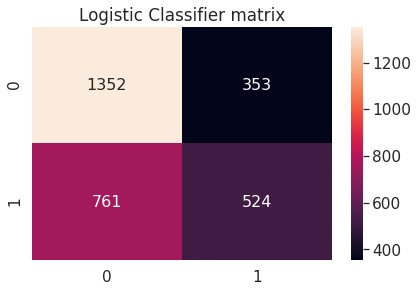

In [0]:
# plot the confusion matrices from both classifiers
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm_lr, annot=True,annot_kws={"size": 16}, fmt='g').set_title('Logistic Classifier matrix')

Text(0.5, 1.0, 'SVM Classifier matrix')

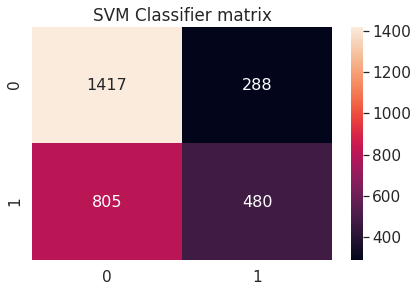

In [0]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm_svm, annot=True,annot_kws={"size": 16}, fmt='g').set_title('SVM Classifier matrix')


## Data Anomalies & Challenges encountered

Some of the challenged faced include,
*    Many indicative features had missing data (Null/unknown values). These null values  must be assigned mean, median values (based on  whether it is a Categorical/Ordianal/Continuous feature) and classified in the dataset.
*    The Transmission feature had a single sample enumerated as 'Manual' while all the remaining samples were classed as 'MANUAL' causing a mismatch in total values
*    The  **inherent class imbalance** in the training set led to a very poor initial logit classifier which cann't be rectified unless the dataset classes are oversampled/undersampled
*    Picking the right EDA for each visualization so that the insight/information is conveyed properly and random/untrue insights are not learned


## Algorithms considered

Traditonal algorithms for binary classifier,
*    Given a dataset of ~70k samples for a classification task, a SVM classifier, Logistic classifier or a decision forest could have been used to benchmark on the training set once the decisive features have been extracted. 
*    Other algorithms like Naive-bayes, Decision tree, KNN classifiers are not known to perform well for this kind of classification task with the dataset size
*    The LR model & SVM model were experimented with in this notebook, with the logit model (74%) outperforming the SVM model (65%) by 16% on the transformed dataset
*    A quick test with different SVM kernels (sigmoid, poly, linear) didn't yield a high performance model.


While class imbalance might be one of the reasons why a SVM rbf classifier was outperformed by the logit classifier in this dataset, working with approximated SVM kernels or decision forests or an ensemble classifier might potentially yield better results. Rectifying the class imbalance and/or carefully hand-picking features from EDA will help achieve better results with the same classifiers as well.